# 階層的クラスタリング

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# フィードデータの読み込み
feeds = pd.read_csv('data/output_en.csv')

# title と summary を結合して text 列を作成
feeds['text'] = feeds['title'].str.cat(feeds['summary'], sep='. ', na_rep='')

# 不要になった列を削除した処理用の DataFrame
df = feeds.drop(['title', 'summary'], axis=1)

# 確認
df

,url,text
0,http://feeds.bbci.co.uk/news/rss.xml,Conservative peer Michelle Mone to take leave ...
1,http://feeds.bbci.co.uk/news/rss.xml,Ambulance staff to strike on 21 December. Serv...
2,http://feeds.bbci.co.uk/news/rss.xml,Strep A schools may be given preventive antibi...
3,http://feeds.bbci.co.uk/news/rss.xml,Eddie Jones sacked by England after review int...
4,http://feeds.bbci.co.uk/news/rss.xml,Tattooists and beauty salons replace banks on ...
...,...,...
783,http://feeds.bbci.co.uk/news/science_and_envir...,Nasa's Orion capsule makes safe return to Eart...
784,http://feeds.bbci.co.uk/news/science_and_envir...,One of Central America's most active volcanoes...
785,http://feeds.bbci.co.uk/news/technology/rss.xml,December 2024 set as date for universal phone ...
786,http://feeds.bbci.co.uk/news/technology/rss.xml,Twitter's paid blue tick re-launches after pau...


### 英語テキストに対する前処理

以下をまとめて行う関数 preprocess() を定義
- トークン化（単語に分割）
- 小文字化
- ストップワードの除去
- ステミング
- 見出し語化

In [2]:
symbols_to_remove = r'["`,.' + r"'" + r']'
stop_words = nltk.corpus.stopwords.words('english')
stop_words += ["'", '"', ':', ';', '.', ',', '-', '!', '?', "'s", '`', '•', '%']
stop_words += ['–', '—', '‘', '’', '“', '”', '…', '|', '#', '$', '&', "''", '(', ')']
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

# 品詞の名称を変換
def wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return None

def preprocess(text):
    tokens = []
    # 品詞のタグ付けをした各トークンについて
    for t in nltk.pos_tag(nltk.tokenize.word_tokenize(text.replace('-', ' '))):
        # 小文字化
        t0 = t[0].lower()
        # 不要な文字の削除
        t0 = re.sub(symbols_to_remove, '', t0)
        # 空文字列になったら次へ
        if t0 == '':
            continue
        # stop_words に含まれていないトークンのみを残す
        if t0 in stop_words:
            continue
        # カンマ区切りが入った数値からカンマを削除
        if t[1] == 'CD':
            t0 = t0.replace(',', '')
        # 見出し語化
        tag = wordnet_tag(t[1])
        if tag is None:
            t0 = lemmatizer.lemmatize(t0)
        else:
            t0 = lemmatizer.lemmatize(t0, tag)
        # ステミング
        t0 = stemmer.stem(t0)
        # リストに追加
        tokens.append(t0)
    # トークンのリストを返す
    return tokens

### テキストのベクトル化 (1)

- Bag of Words (BoW)

In [3]:
# 500行をランダムに抽出
df_sample = df.sample(n=500)

# CountVectorizer によりベクトル化
vectorizer = CountVectorizer(tokenizer=preprocess)
vector = vectorizer.fit_transform(df_sample.text)

### 階層的クラスタリング (1)

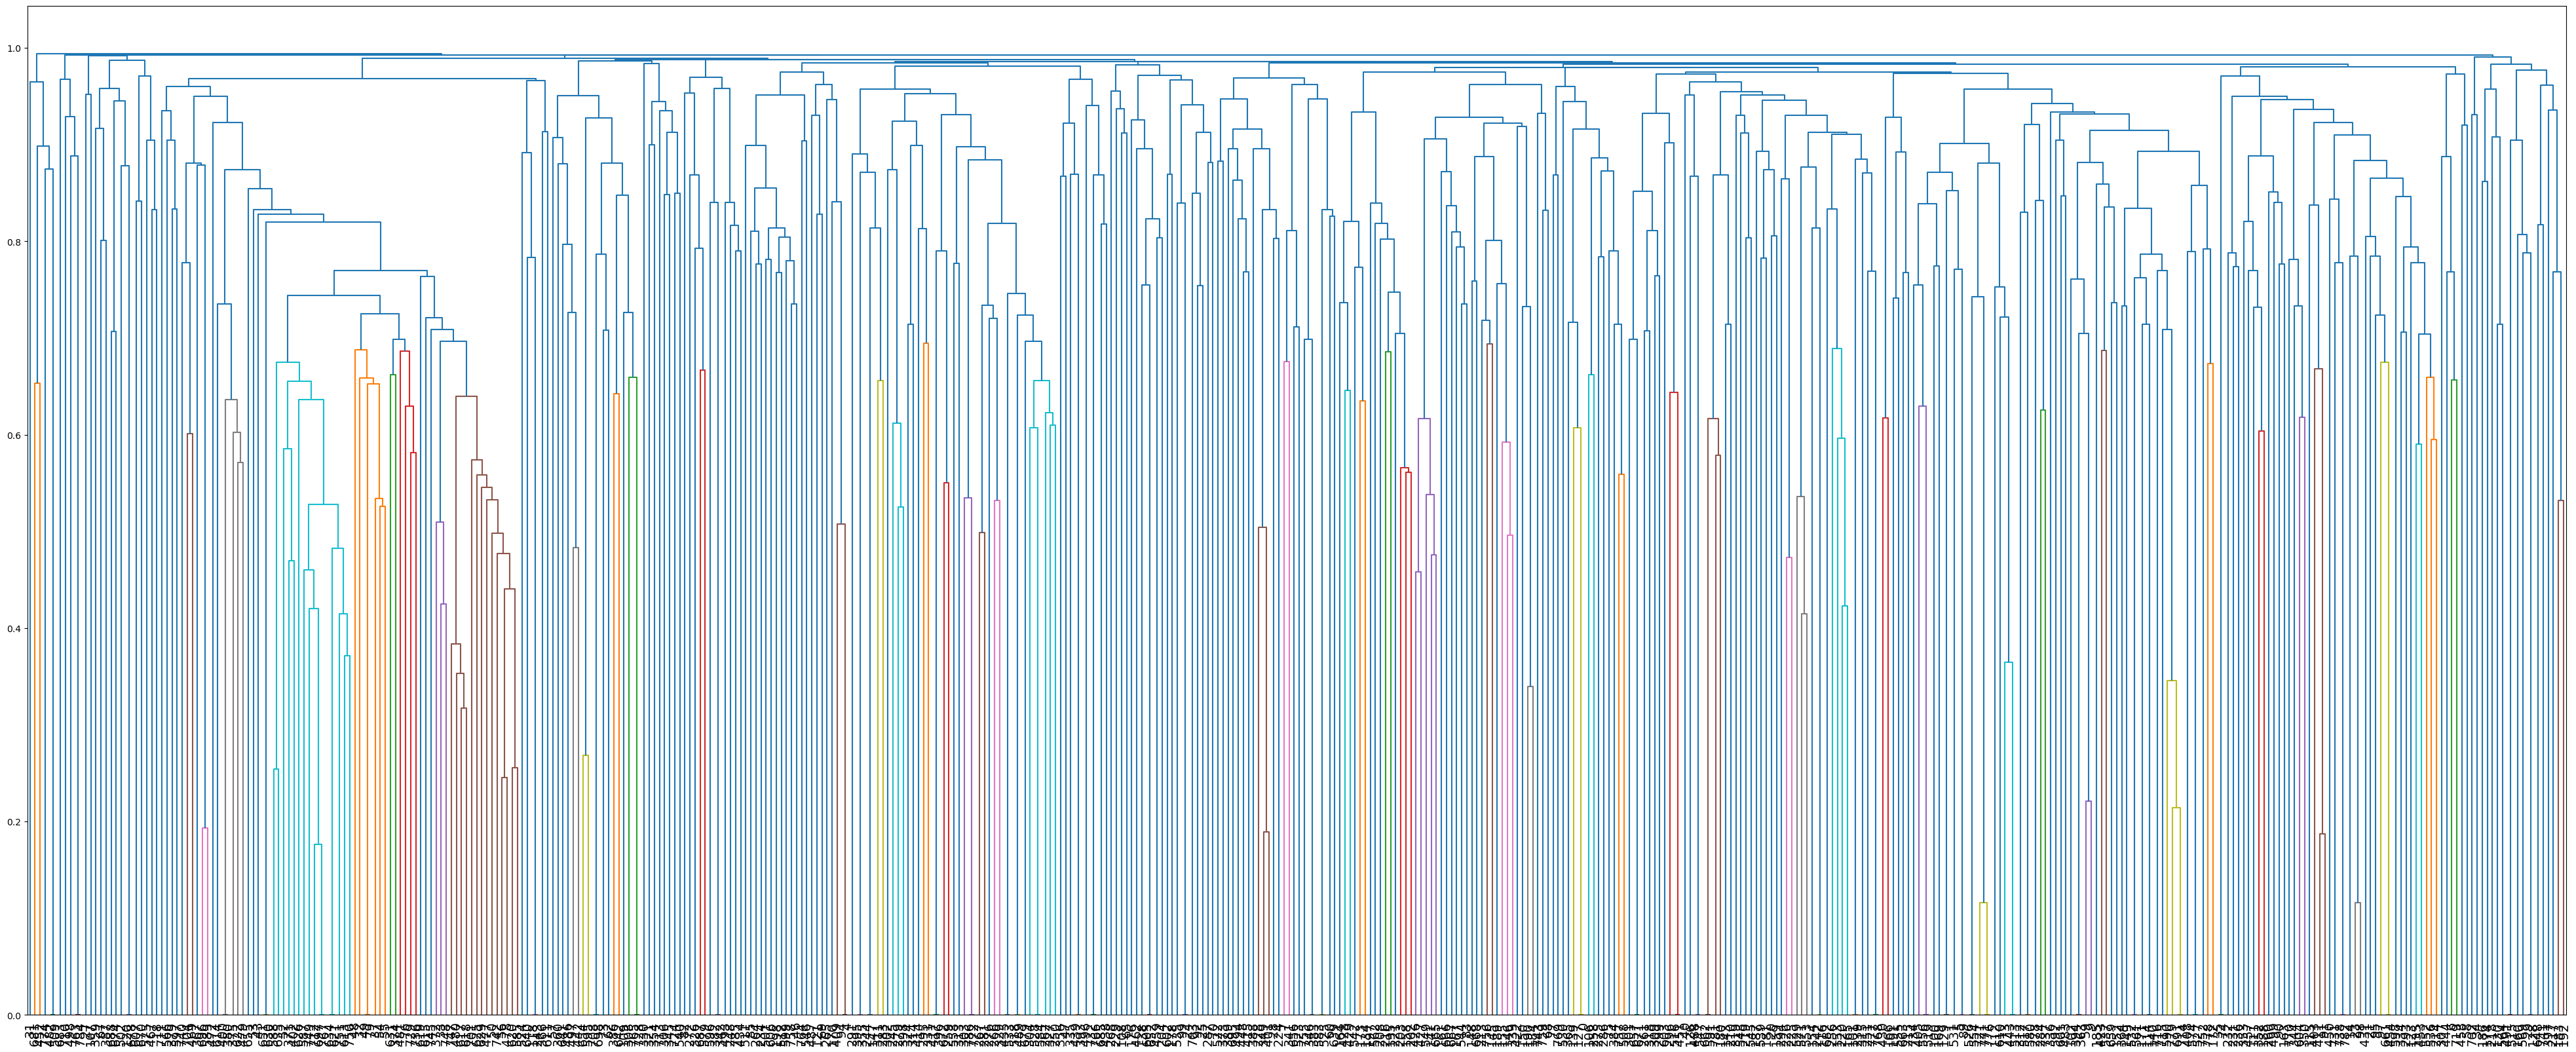

In [4]:
# 階層的凝集クラスタリング
# - metric='cosine' コサイン距離
# - method='average' 平均非類似度（コサイン距離ではward法は使えないため）
clusters = linkage(vector.todense(), method='average', metric='cosine')

# 樹形図を作成
plt.figure(figsize=(50, 20))
dendr = dendrogram(clusters, labels=df_sample.index, leaf_font_size=14)

### テキストのベクトル化 (2)

- TF-IDF

In [ ]:
# TfidfVectorizer によりベクトル化
tf_idf_vectorizer = TfidfVectorizer(tokenizer=preprocess)
tf_idf_vector = tf_idf_vectorizer.fit_transform(df_sample.text)

### 階層的クラスタリング (2)

In [ ]:
# 階層的凝集クラスタリング
# - metric='cosine' コサイン距離
# - method='average' 平均非類似度（コサイン距離ではward法は使えないため）
clusters = linkage(vector.todense(), method='average', metric='cosine')

# 樹形図を作成
plt.figure(figsize=(50, 20))
dendr = dendrogram(clusters, labels=df_sample.index, leaf_font_size=14)

<hr>

### クラスタ番号の取得

クラスタリングの結果を取得する。

In [ ]:
from scipy.cluster.hierarchy import cut_tree

n_clusters = 30

# cut_tree: 指定したクラスタ数でのラベル（クラスタ番号）を取得
# - np.ndarray.flatten: cut_tree は多次元配列で返すので、1次元配列に変換
labels = np.ndarray.flatten(cut_tree(clusters, n_clusters))

# 結果を DataFrame にまとめる
df_cluster = pd.DataFrame(labels, columns=['cluster'])
df_cluster['text'] = df.text

# 確認
df_cluster

In [ ]:
# それぞれのクラスタの内容を出力
for i in range(0, n_clusters):
    print(df_cluster[df_cluster.cluster == i])